# Learning pKd from ligand ring singatures

### Model choice

We need a simple model, something that can run on a conventional machine, yet is still capable of grasping complex non-linear relationships. Furthermore, given that these signatures are sparse and discrete, we need something that is adaptable to this data. For this reason, we are starting with : 

### XGBoost


In [23]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [32]:
# Load the data
DATA_DIR = "../data"
INTERIM_DIR = Path(DATA_DIR, "interim")
DATASET_PATH = Path(INTERIM_DIR, "reg_preprocessed_1.npz")

data = np.load(DATASET_PATH)
X_train = data["X_train"]
X_test = data["X_test"]
y_train = data["y_train"]
y_test = data["y_test"]

In [33]:
model = XGBRegressor(
    n_estimators=1000,     
    learning_rate=0.05,      
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

# Fit model with eval sets
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Again, we notice a nasty tendency towards overfitting

Left alone, the model will of course learn every correlation there exists between morgan signature features, and pKd. This will give us a massive R^2, similar to linear regression, without learning any of the underlying chemical characteristics of ligands.

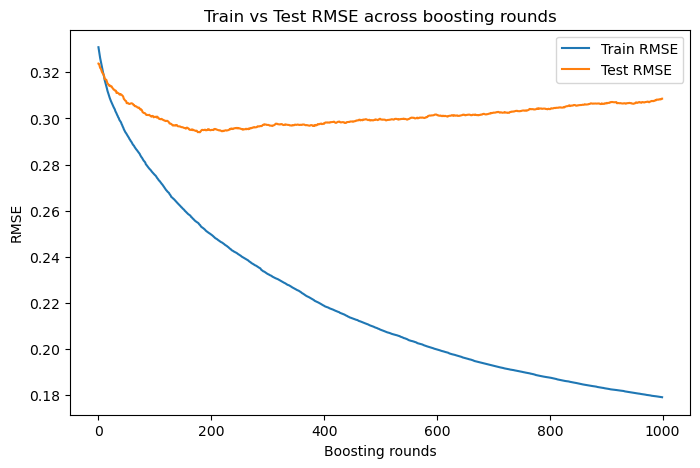

In [34]:
# Extract training history
evals_result = model.evals_result()

train_rmse = evals_result['validation_0']['rmse']
test_rmse  = evals_result['validation_1']['rmse']

# Plotting learning curves 
plt.figure(figsize=(8, 5))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.xlabel('Boosting rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Train vs Test RMSE across boosting rounds')
plt.show()


In [35]:
# Final metrics
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)
pearson_r, p_value = pearsonr(y_test, y_pred_test)

print(f"Train R²: {r2_score(y_train, y_pred_train):.3f}")
print(f"Train RMSE: {mean_squared_error(y_train, y_pred_train):.3f}")
print()
print(f"Test  R²: {r2_score(y_test, y_pred_test):.3f}")
print(f"Test RMSE: {mean_squared_error(y_test, y_pred_test):.3f}")
print()
print(f"Pearson R: {pearson_r:.3f}")

Train R²: 0.710
Train RMSE: 0.032

Test  R²: 0.094
Test RMSE: 0.095

Pearson R: 0.374


### The first thing we might try is to add a minimum child weight

After playing around with it, I saw  that setting it to 45 provided with the greatest (although still modest) improvement to test RMSE and Pearson's R, while simultaneously bringing the train RMSE and R² closer to the test results

In [36]:
model2 = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6, 
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42,
    min_child_weight=45, 
)

# Fit model with eval sets
model2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### We can see that the model is still overfitting, but it's better

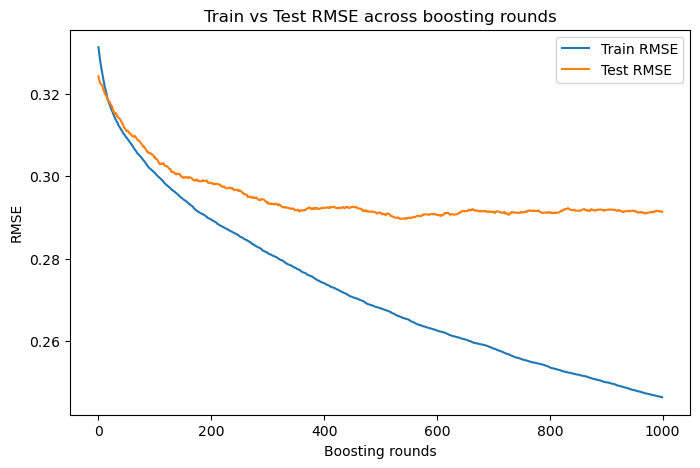

In [37]:
# Extract training history
evals_result = model2.evals_result()

train_rmse = evals_result['validation_0']['rmse']
test_rmse  = evals_result['validation_1']['rmse']

# Plotting learning curves 
plt.figure(figsize=(8, 5))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.xlabel('Boosting rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Train vs Test RMSE across boosting rounds')
plt.show()

In [38]:
# Final metrics
y_pred_train = model2.predict(X_train)
y_pred_test  = model2.predict(X_test)
pearson_r, p_value = pearsonr(y_test, y_pred_test)

print(f"Train R²: {r2_score(y_train, y_pred_train):.3f}")
print(f"Train RMSE: {mean_squared_error(y_train, y_pred_train):.3f}")
print()
print(f"Test  R²: {r2_score(y_test, y_pred_test):.3f}")
print(f"Test RMSE: {mean_squared_error(y_test, y_pred_test):.3f}")
print()
print(f"Pearson R: {pearson_r:.3f}")

Train R²: 0.451
Train RMSE: 0.061

Test  R²: 0.192
Test RMSE: 0.085

Pearson R: 0.444


### Playing with depth and gamma regularization to see if we can further improve our results

Some slight gamma regularization seems to somewhat alleviate overfitting, but it quickly eats up on the model's test accuracy if left unchecked. 

In [39]:
model2 = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10, 
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42,
    min_child_weight=45, 
    gamma=0.3
)

# Fit model with eval sets
model2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


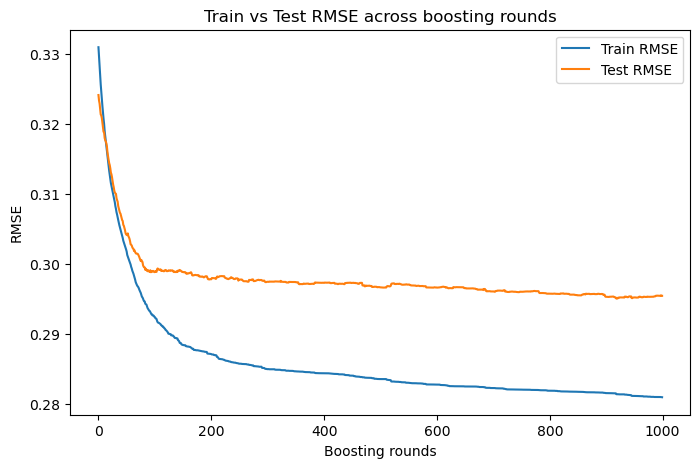

In [40]:
# Extract training history
evals_result = model2.evals_result()

train_rmse = evals_result['validation_0']['rmse']
test_rmse  = evals_result['validation_1']['rmse']

# Plotting learning curves 
plt.figure(figsize=(8, 5))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.xlabel('Boosting rounds')
plt.ylabel('RMSE')
plt.legend()
plt.title('Train vs Test RMSE across boosting rounds')
plt.show()

In [41]:
# Final metrics
y_pred_train = model2.predict(X_train)
y_pred_test  = model2.predict(X_test)
pearson_r, p_value = pearsonr(y_test, y_pred_test)

print(f"Train R²: {r2_score(y_train, y_pred_train):.3f}")
print(f"Train RMSE: {mean_squared_error(y_train, y_pred_train):.3f}")
print()
print(f"Test  R²: {r2_score(y_test, y_pred_test):.3f}")
print(f"Test RMSE: {mean_squared_error(y_test, y_pred_test):.3f}")
print()
print(f"Pearson R: {pearson_r:.3f}")

Train R²: 0.286
Train RMSE: 0.079

Test  R²: 0.169
Test RMSE: 0.087

Pearson R: 0.422


### Considering that we haven't introduced any protein information yet, this is probably as good as it's going to get

On the next notebook, we'll dive deeper into the data that we have